In [2]:
import os
import sys
import gzip
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

import seaborn as sns

import umap
import umap.plot

from PIL import Image
from io import BytesIO
import base64

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Spectral, Pastel2

%load_ext autoreload
%autoreload 2

In [3]:
# print out package versions for reproducibility
# if you are having problems, make sure to use the same package versions
# we used:
# Python 3.7.10
# np: 1.21.5 
# pd: 1.3.5 
# sns: 0.12.2 
# umap: 0.5.3 
# PIL: 9.3.0 
# bokeh: 2.4.3 
# matplotlib: 3.5.2

import PIL
import bokeh
import matplotlib

!python --version

print(
    f"\nnp: {np.__version__}",
    f"\npd: {pd.__version__}",
    f"\nsns: {sns.__version__}",
    f"\numap: {umap.__version__}",
    f"\nPIL: {PIL.__version__}",
    f"\nbokeh: {bokeh.__version__}",
    f"\nmatplotlib: {matplotlib.__version__}",
 )

Python 3.9.7

np: 1.20.3 
pd: 1.3.4 
sns: 0.11.2 
umap: 0.5.3 
PIL: 8.4.0 
bokeh: 2.4.1 
matplotlib: 3.4.3


### set path to recordings metadata and segmentation masks and load everything

In [4]:
# set paths
segmentation_masks_path = os.path.join(".", "segmentation_masks.pkl")
recordings_metadata_path = os.path.join(".", "recordings_metadata.pklz")

# load segmentation masks
with gzip.open(segmentation_masks_path, 'rb') as fp:
    segmentation_masks = pickle.load(fp)

# load recordings metadata
with gzip.open(recordings_metadata_path, 'rb') as fp:
    recordings_metadata = pickle.load(fp)

### pickle files contain data for the following groups

In [5]:
groups = [
    "reunion_ctrl", # reunion control group
    "reunion_dq", # reunion + hM3Dq group
    "sep_ctrl", # separation control group
    "sep_dq", # separation + hM3Dq group
    "opto_acr", # optogenetic stGtACR2 group
    "opto_ctrl", # optogenetic control group
    "reunion_kir", # reunion + Kir2.1 group
    "reunion_kir_ctrl", # reunion control group
    "sep_kir", # separation + Kir2.1 group
    "sep_kir_ctrl", # separation control group
]

### plot sample segmentation masks

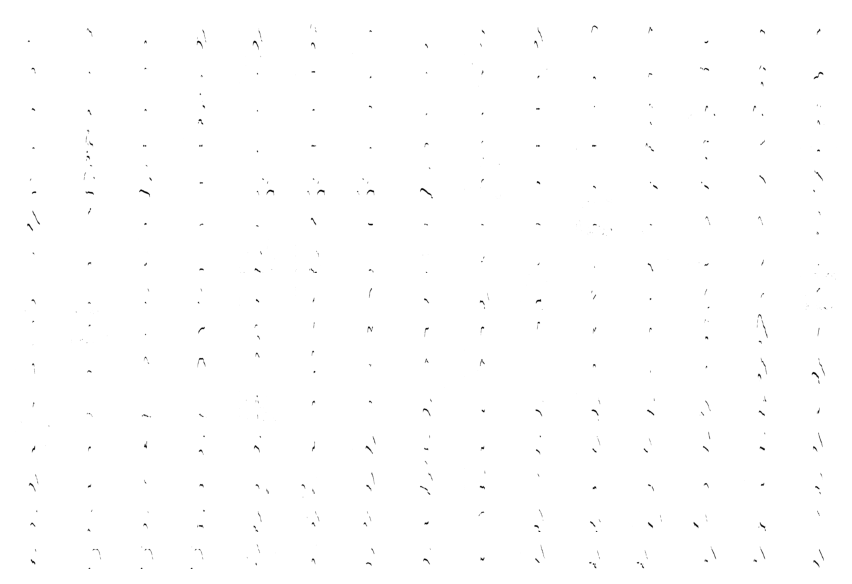

In [6]:
fig, ax_array = plt.subplots(15, 15, dpi=150)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(segmentation_masks['reunion_ctrl'][i].reshape(256, 256), cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

### reformat data for UMAP analysis

In [7]:
# create label vector for plotting purposes
# each group is associated with a unique number

targets = np.hstack(
    [
        np.repeat(1, segmentation_masks["reunion_ctrl"].shape[0]),
        np.repeat(2, segmentation_masks["reunion_dq"].shape[0]),
        np.repeat(3, segmentation_masks["sep_ctrl"].shape[0]),
        np.repeat(4, segmentation_masks["sep_dq"].shape[0]),
        np.repeat(5, segmentation_masks["opto_acr"].shape[0]),
        np.repeat(6, segmentation_masks["opto_ctrl"].shape[0]),
        np.repeat(7, segmentation_masks["reunion_kir"].shape[0]),
        np.repeat(8, segmentation_masks["reunion_kir_ctrl"].shape[0]),
        np.repeat(9, segmentation_masks["sep_kir"].shape[0]),
        np.repeat(10, segmentation_masks["sep_kir_ctrl"].shape[0]),
    ]
)
target_ids = np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) # combine datasets into a single vector to run UMAP


# flatten all segmentation masks into one array
segmentation_masks = np.vstack(
    [
        segmentation_masks["reunion_ctrl"],
        segmentation_masks["reunion_dq"],
        segmentation_masks["sep_ctrl"],
        segmentation_masks["sep_dq"],
        segmentation_masks["opto_acr"],
        segmentation_masks["opto_ctrl"],
        segmentation_masks["reunion_kir"],
        segmentation_masks["reunion_kir_ctrl"],
        segmentation_masks["sep_kir"],
        segmentation_masks["sep_kir_ctrl"],
    ]
)

# combine all classes into a single vector for plotting purposes
classes_vector = []
for idx, group in enumerate(groups):
    group_vector = []
    this_data = recordings_metadata[0][group]
    print(f"\ngroup {group}: there are {len(this_data)} recordings")
    for recording_data in this_data:
        this_rec_classes = recording_data['Class'].loc[recording_data['Class'] != 'noise_dist']
        group_vector.append(this_rec_classes)

    group_vector = np.hstack(group_vector)
    print(f"there are are {len(group_vector)} vocals in group {group}")
    classes_vector.append(group_vector)

classes_vector = np.hstack(classes_vector)
classes_names, classes_categorical = np.unique(classes_vector, return_inverse=True)
print(f"\n\nthere are are {len(classes_vector)} vocals in the dataset")
print(f"missing {segmentation_masks.shape[0]-len(classes_vector)} vocals")


group reunion_ctrl: there are 8 recordings
there are are 727 vocals in group reunion_ctrl

group reunion_dq: there are 15 recordings
there are are 859 vocals in group reunion_dq

group sep_ctrl: there are 21 recordings
there are are 25473 vocals in group sep_ctrl

group sep_dq: there are 40 recordings
there are are 12390 vocals in group sep_dq

group opto_acr: there are 5 recordings
there are are 323 vocals in group opto_acr

group opto_ctrl: there are 3 recordings
there are are 19 vocals in group opto_ctrl

group reunion_kir: there are 11 recordings
there are are 2134 vocals in group reunion_kir

group reunion_kir_ctrl: there are 10 recordings
there are are 657 vocals in group reunion_kir_ctrl

group sep_kir: there are 22 recordings
there are are 32327 vocals in group sep_kir

group sep_kir_ctrl: there are 20 recordings
there are are 28270 vocals in group sep_kir_ctrl


there are are 103179 vocals in the dataset
missing 0 vocals


### load pre-trained UMAP model

In [ ]:
# # load UMAP from previous run
# # or run UMAP again using the next cell
#umap_model_path = os.path.join(".", "umap_model.pklz")
    
# # load umap model
#with gzip.open(umap_model_path, 'rb') as fp:
    #umap_model = pickle.load(fp)

### sample from dataset

In [8]:
# this is destructive, rerun cells above
num_samples = 500
samples_idx = np.random.choice(len(segmentation_masks), 500)
segmentation_masks = segmentation_masks[samples_idx]
targets = targets[samples_idx]
classes_vector = classes_vector[samples_idx]
classes_categorical = classes_categorical[samples_idx]

### run UMAP!

In [9]:
# UMAP possible set of parameters
# umap.UMAP(a=None, angular_rp_forest=False, b=None,
#      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
#      local_connectivity=1.0, low_memory=False, metric='euclidean',
#      metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
#      n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
#      output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
#      target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
#      transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)


# uncomment the last two lines to run a new UMAP model or skip ahead to load a previous model
# if your session is getting killed because of memory errors use low_memory=True
# runs a bit slower but will not crash

umap_model = umap.UMAP(metric='dice', n_components=2, n_neighbors=25, low_memory=False)
umap_model.fit(segmentation_masks)

/Users/yuexuanli/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(angular_rp_forest=True, low_memory=False, metric='dice', n_neighbors=25, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

### (optional) save your new UMAP model

In [9]:
# save UMAP model so you can just load it next time
# be careful not to overwrite previous models
# model_name = "new_umap_model.pklz"

# # save UMAP model
# with gzip.GzipFile(model_path, 'wb') as fp:
#     pickle.dump(umap_model, fp, protocol=4)

### project data using UMAP

In [10]:
# use UMAP model to create embedding
embedding = umap_model.transform(segmentation_masks)

### prepare data and plot!

In [11]:
# create pandas dataframe for plotting purposes

column_values = ['x', 'y', 'group']
df = pd.DataFrame(data=list(zip(
                    embedding[:,0],
                    embedding[:,1],
                    targets
                    )),
                  columns = column_values)

# artificially move UMAP embeddings to plot density maps side-by-side
df2 = df.copy()
df2.loc[df2['group'] == 2, 'x'] = df2.loc[df2['group'] == 2, 'x'] + 25 * 1
df2.loc[df2['group'] == 3, 'x'] = df2.loc[df2['group'] == 3, 'x'] + 25 * 2
df2.loc[df2['group'] == 4, 'x'] = df2.loc[df2['group'] == 4, 'x'] + 25 * 3
df2.loc[df2['group'] == 5, 'x'] = df2.loc[df2['group'] == 5, 'x'] + 25 * 4

df2.loc[df2['group'] == 6, 'x'] = df2.loc[df2['group'] == 6, 'x']
df2.loc[df2['group'] == 7, 'x'] = df2.loc[df2['group'] == 7, 'x'] + 25 * 1
df2.loc[df2['group'] == 8, 'x'] = df2.loc[df2['group'] == 8, 'x'] + 25 * 2
df2.loc[df2['group'] == 9, 'x'] = df2.loc[df2['group'] == 9, 'x'] + 25 * 3
df2.loc[df2['group'] == 10, 'x'] = df2.loc[df2['group'] == 10, 'x'] + 25 * 4
df2.loc[df2['group'] == 6, 'y'] = df2.loc[df2['group'] == 6, 'y'] - 15
df2.loc[df2['group'] == 7, 'y'] = df2.loc[df2['group'] == 7, 'y'] - 15
df2.loc[df2['group'] == 8, 'y'] = df2.loc[df2['group'] == 8, 'y'] - 15
df2.loc[df2['group'] == 9, 'y'] = df2.loc[df2['group'] == 9, 'y'] - 15
df2.loc[df2['group'] == 10, 'y'] = df2.loc[df2['group'] == 10, 'y'] - 15

### plot density maps by group

plotting for groups (clockwise): ['reunion_ctrl', 'reunion_dq', 'sep_ctrl', 'sep_dq', 'opto_acr', 'opto_ctrl', 'reunion_kir', 'reunion_kir_ctrl', 'sep_kir', 'sep_kir_ctrl']


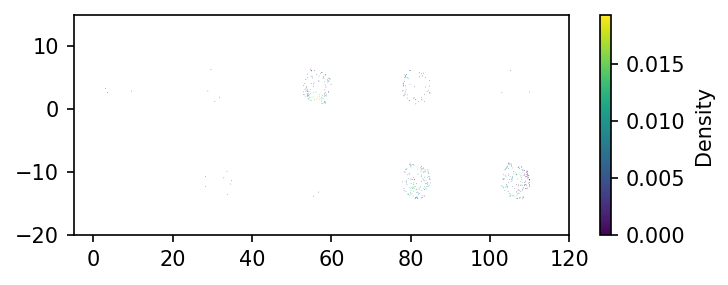

In [12]:
print(f"plotting for groups (clockwise): {groups}")

def density_scatter(x, y, fig=None, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(dpi=300)
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]),
                 0.5*(y_e[1:]+y_e[:-1])),
                data,
                np.vstack([x,y]).T,
                method="splinef2d",
                bounds_error=False)

    # to be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, s=0.1, edgecolors='none', c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

# plot with raw points
fig , ax = plt.subplots(figsize=(5, 2), dpi=150)
density_scatter(df2[np.isfinite(df2['x'])]['x'].to_numpy(),
                df2[np.isfinite(df2['y'])]['y'].to_numpy(),
                fig=fig,
                ax=ax,
                bins=[40, 40])
plt.xlim([-5, 120])
plt.ylim([-20, 15])
plt.tight_layout()
plt.show()

/gpfs/gibbs/project/dietrich/gms58/conda_envs/segm/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  """


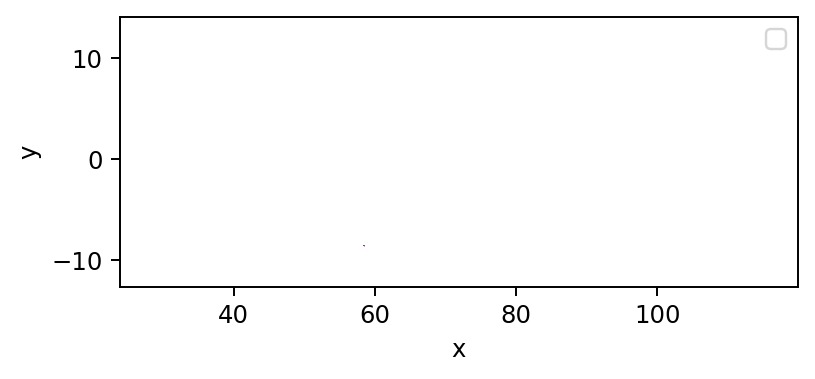

In [17]:
# plot kernel density estimate (KDE) only
fig, ax = plt.subplots(figsize=(5,2), dpi=175)
sns.kdeplot(data=df2, x='x', y='y', hue='group',
            levels=6, fill=True,
            alpha=1)
plt.legend([])
plt.show()

### plot UMAP embeddings

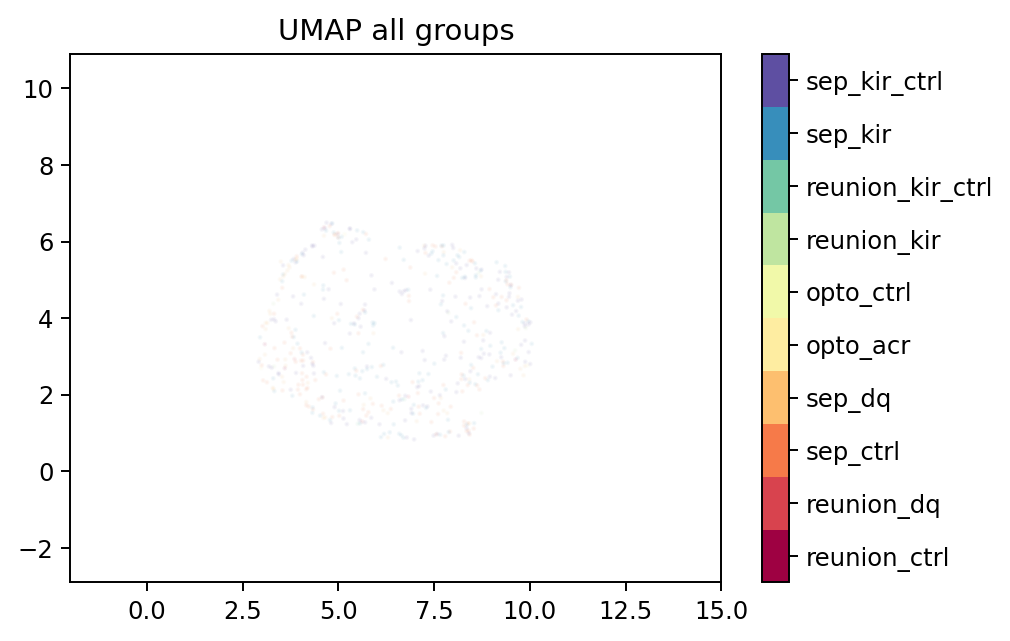

In [13]:
# plot UMAP embedding by group

fig = plt.figure(dpi=175)
plt.scatter(embedding[:, 0], embedding[:, 1], c=targets, cmap='Spectral', s=1, alpha=0.05)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(boundaries=np.arange(len(groups)+1)+0.5)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_ticks(np.arange(len(groups))+1)
cbar.set_ticklabels(groups)
plt.title('UMAP all groups', fontsize=12);
plt.xlim([-2, 15])
plt.ylim([-4, 12])
plt.show()

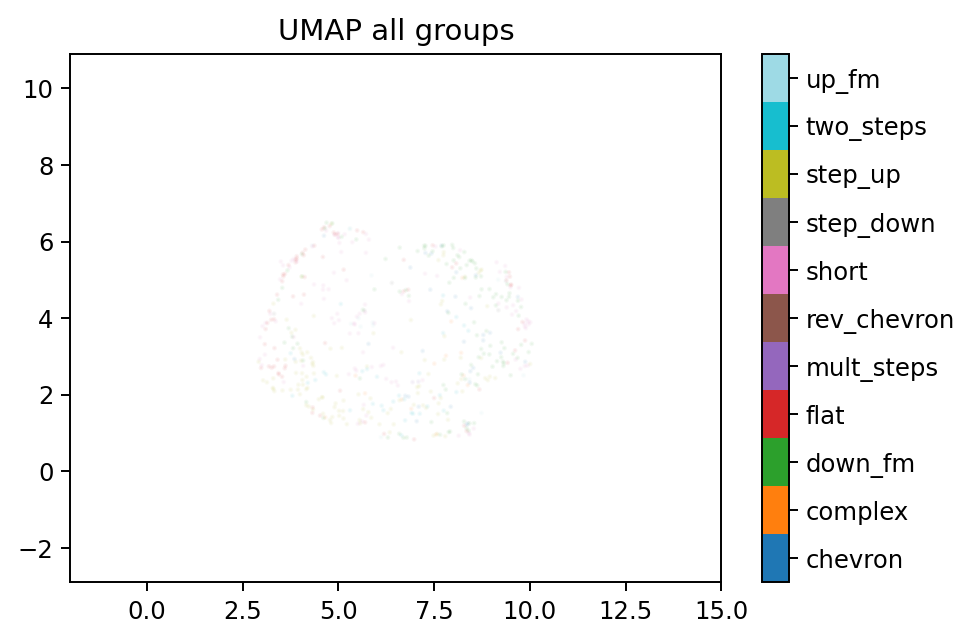

In [14]:
# plot UMAP embedding by vocal class

fig = plt.figure(dpi=175)
plt.scatter(embedding[:, 0], embedding[:, 1], c=classes_categorical+1, cmap='tab20', s=1, alpha=0.05)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(boundaries=np.arange(len(classes_names)+1)+0.5)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_ticks(np.arange(len(classes_names))+1)
cbar.set_ticklabels(classes_names)
plt.title('UMAP all groups', fontsize=12);
plt.xlim([-2, 15])
plt.ylim([-4, 12])
plt.show()

0


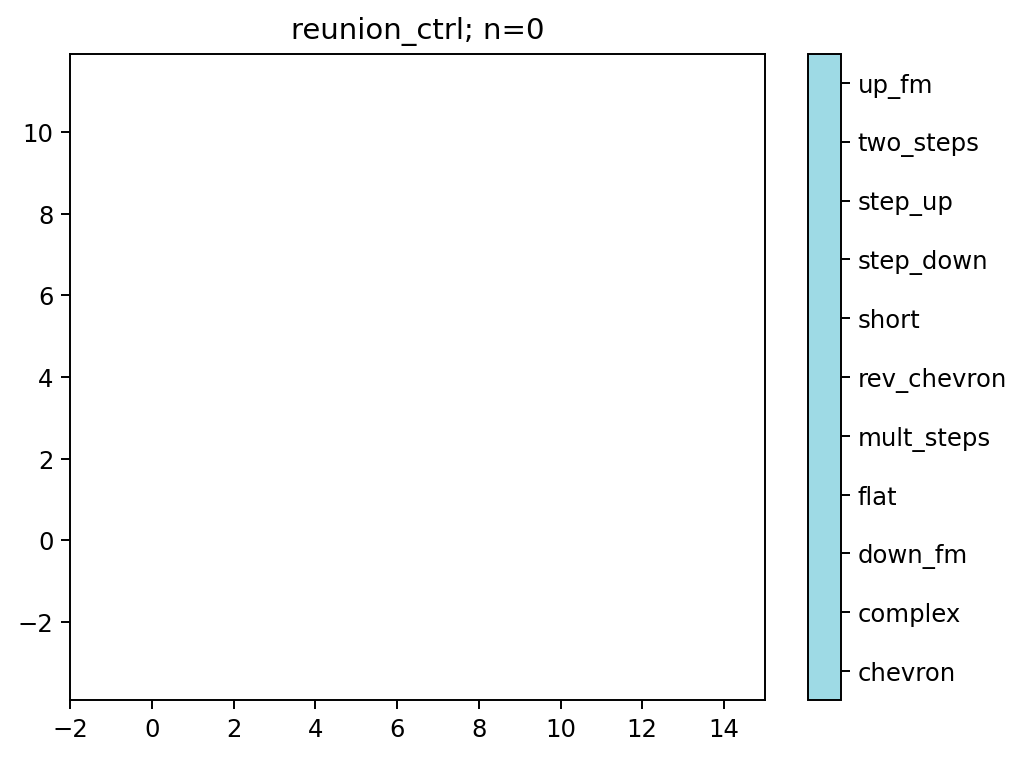

1


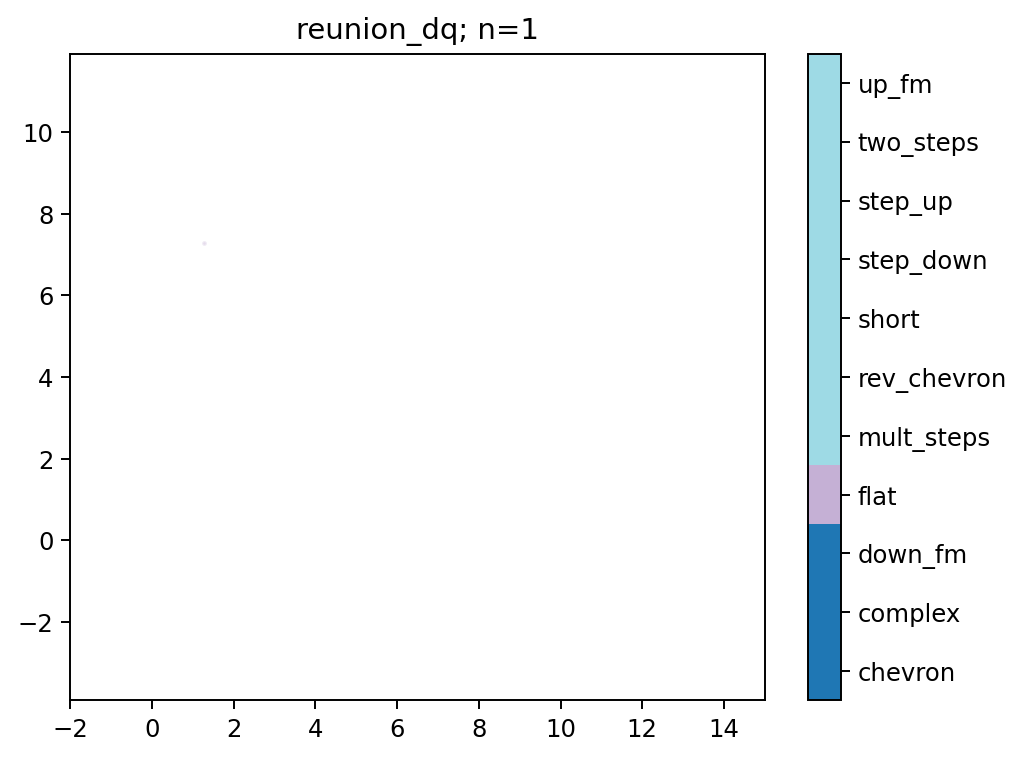

144


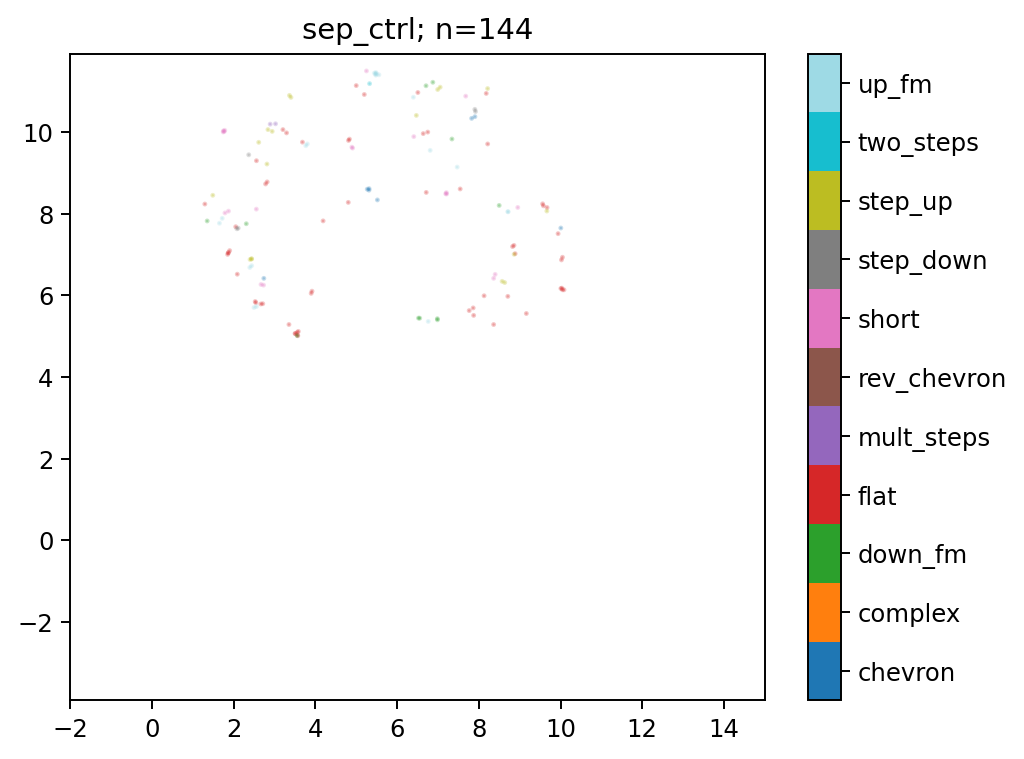

57


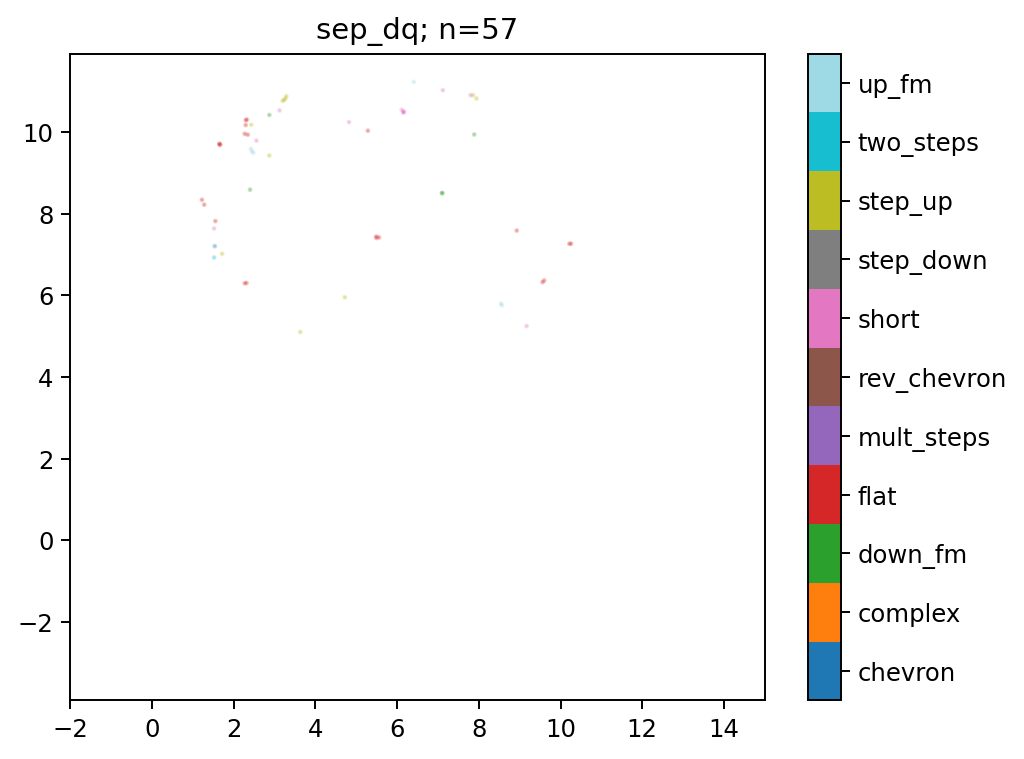

3


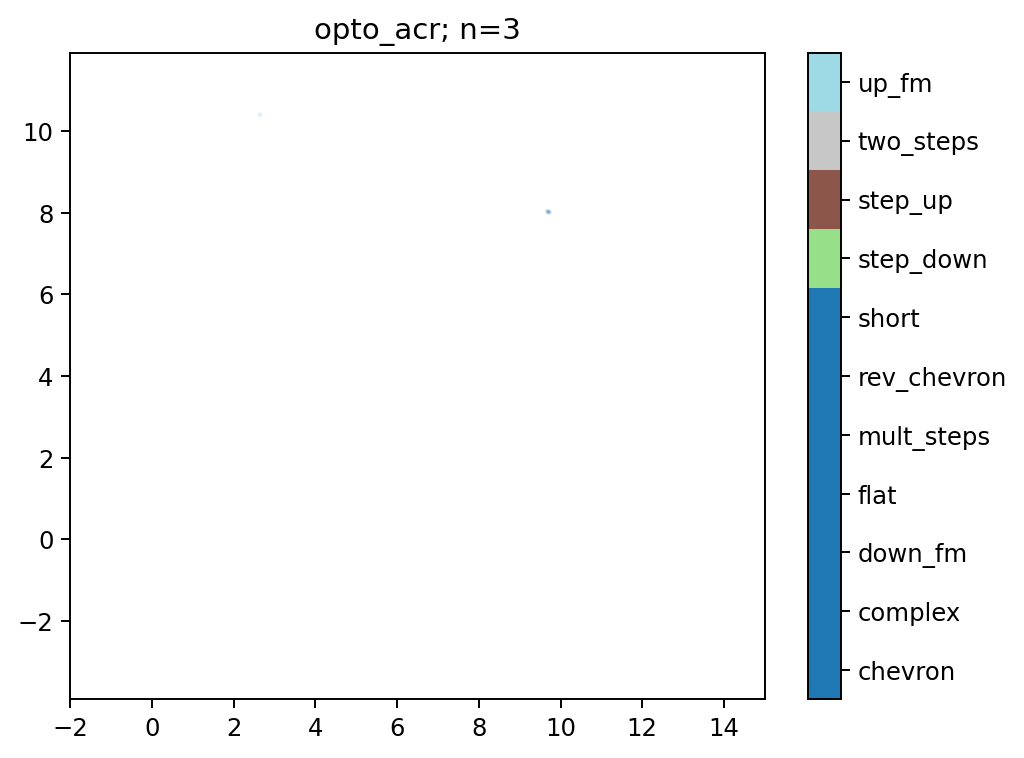

0


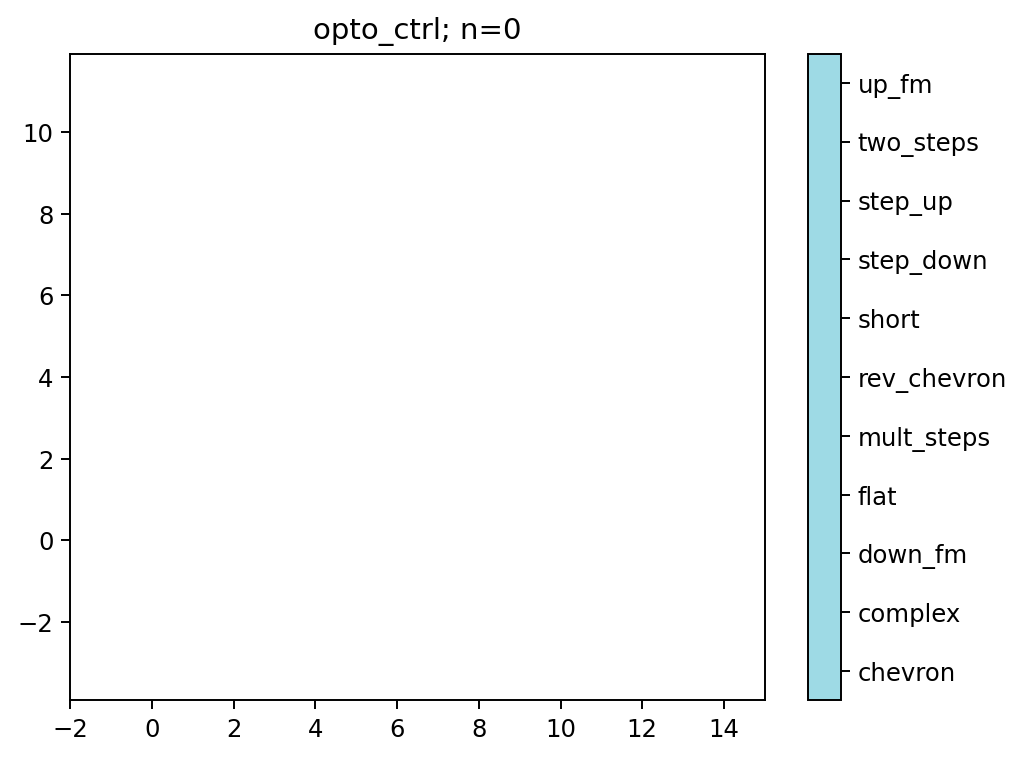

10


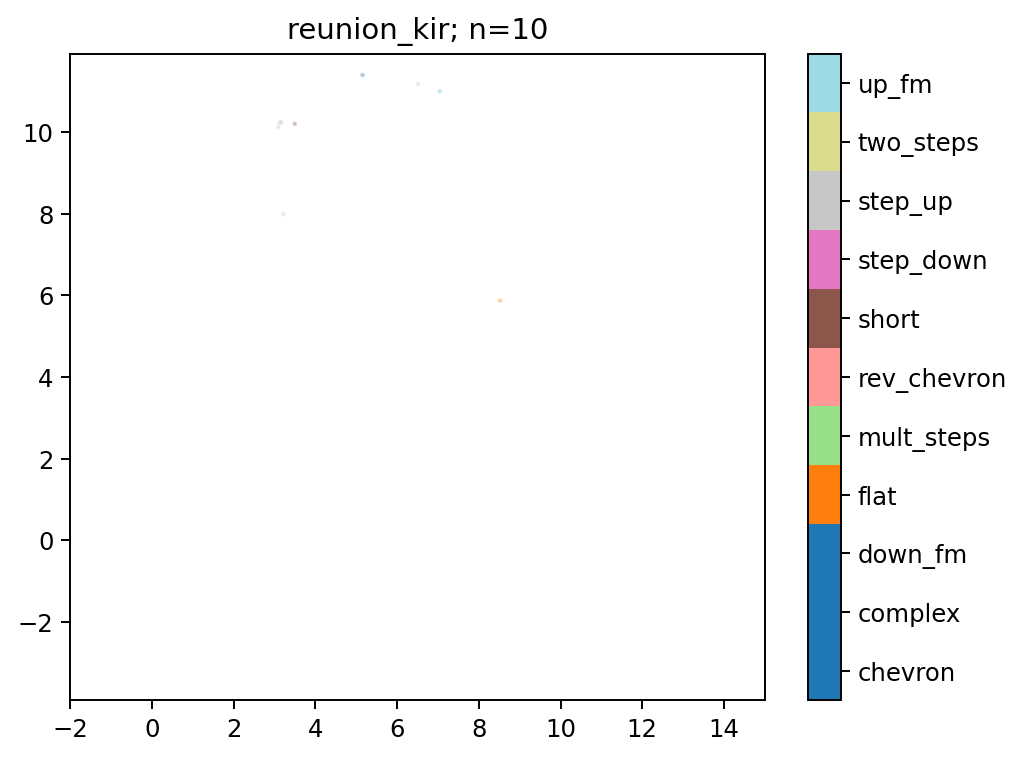

3


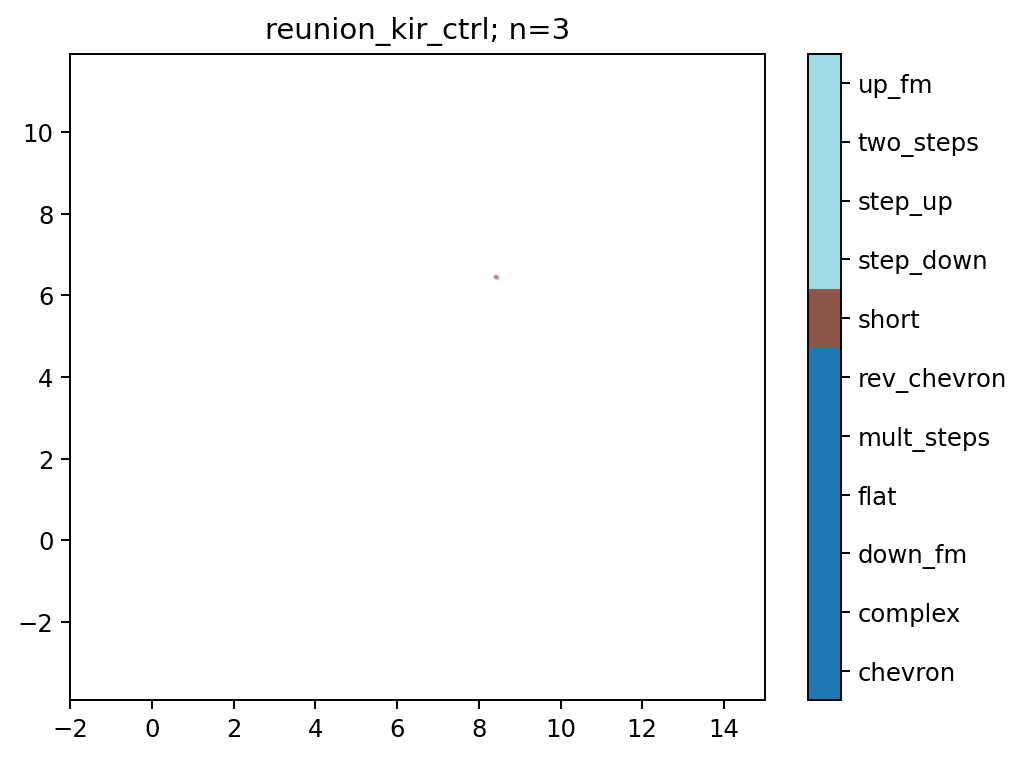

158


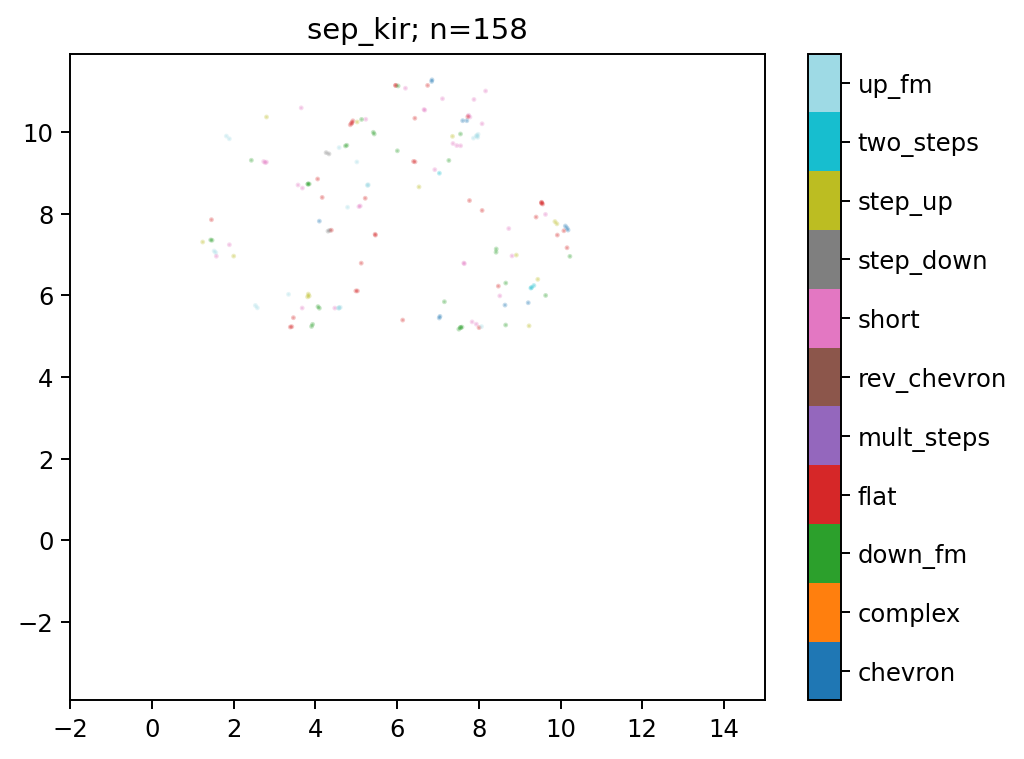

124


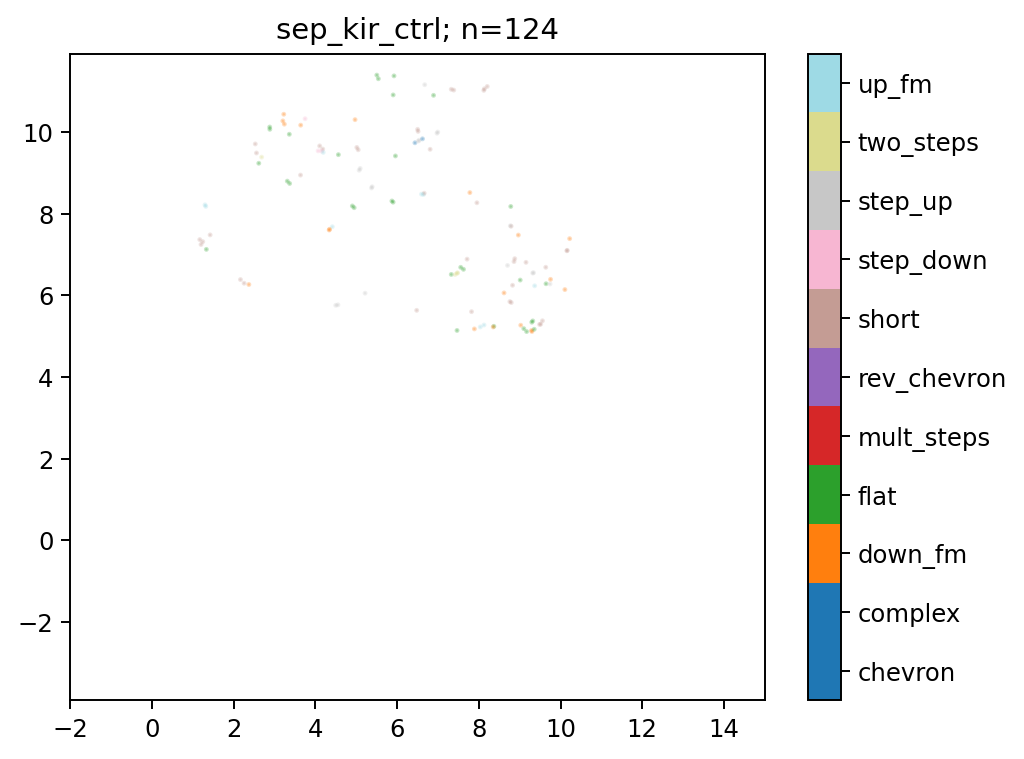

In [22]:
# plot UMAP embedding by vocal class per group

for gid in target_ids:
    
    this_target = (targets == gid)
    print(sum(this_target))
    fig = plt.figure(dpi=175)
    plt.scatter(embedding[this_target, 0],
                embedding[this_target, 1],
                c=classes_categorical[this_target]+1,
                cmap='tab20',
                s=1,
                alpha=0.25)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(len(classes_names)+1)+0.5)
    cbar.set_alpha(1)
    cbar.draw_all()
    cbar.set_ticks(np.arange(len(classes_names))+1)
    cbar.set_ticklabels(classes_names)
    plt.title(f'{groups[gid-1]}; n={sum(this_target)}', fontsize=12);
    plt.xlim([-2, 15])
    plt.ylim([-4, 12])
    plt.show() 

data points: 21
by groups: [('sep_ctrl', 8), ('sep_dq', 1), ('sep_kir', 12)];


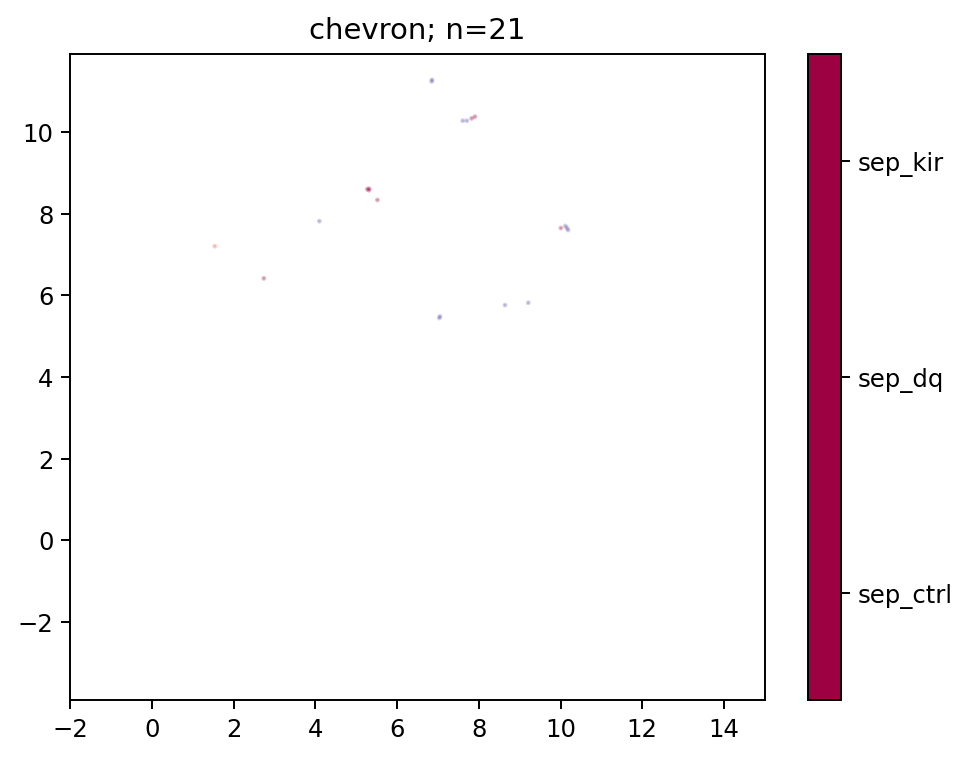

data points: 2
by groups: [('sep_kir_ctrl', 2)];


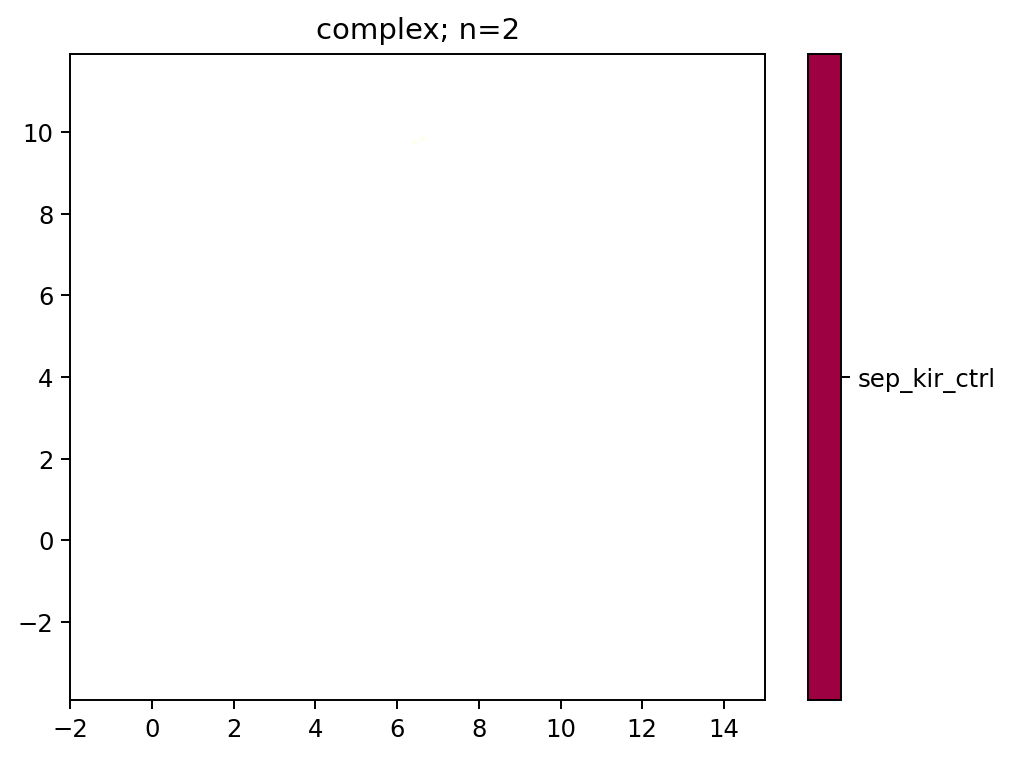

data points: 66
by groups: [('sep_ctrl', 11), ('sep_dq', 5), ('reunion_kir', 1), ('sep_kir', 30), ('sep_kir_ctrl', 19)];


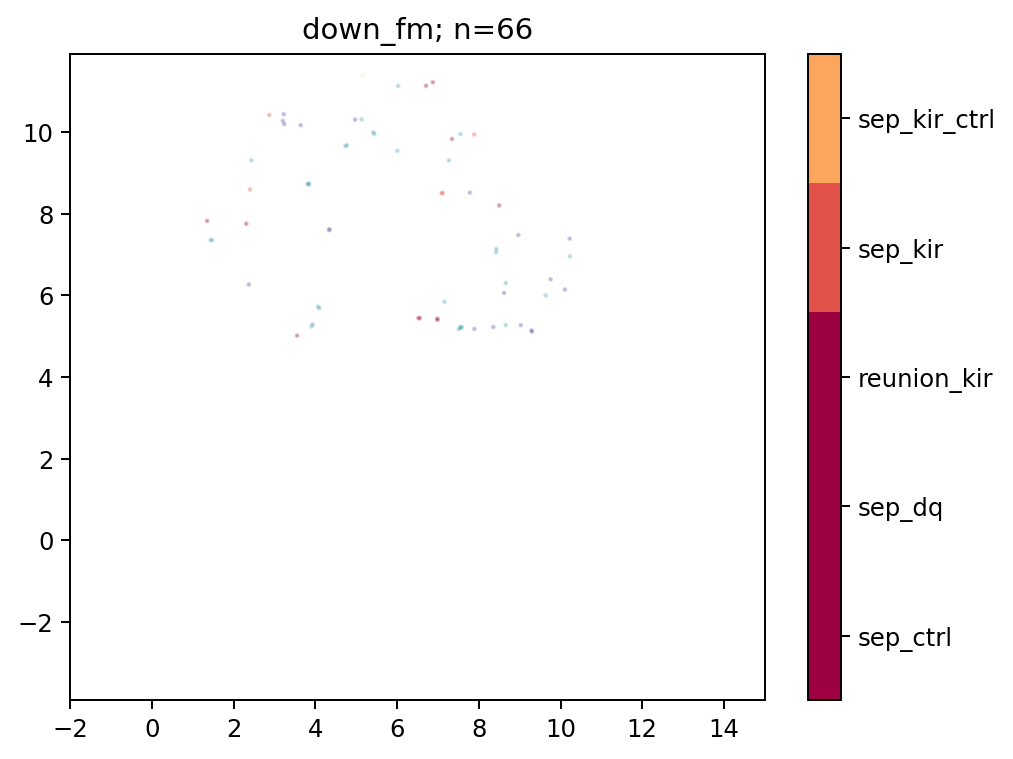

data points: 151
by groups: [('reunion_dq', 1), ('sep_ctrl', 59), ('sep_dq', 22), ('reunion_kir', 1), ('sep_kir', 37), ('sep_kir_ctrl', 31)];


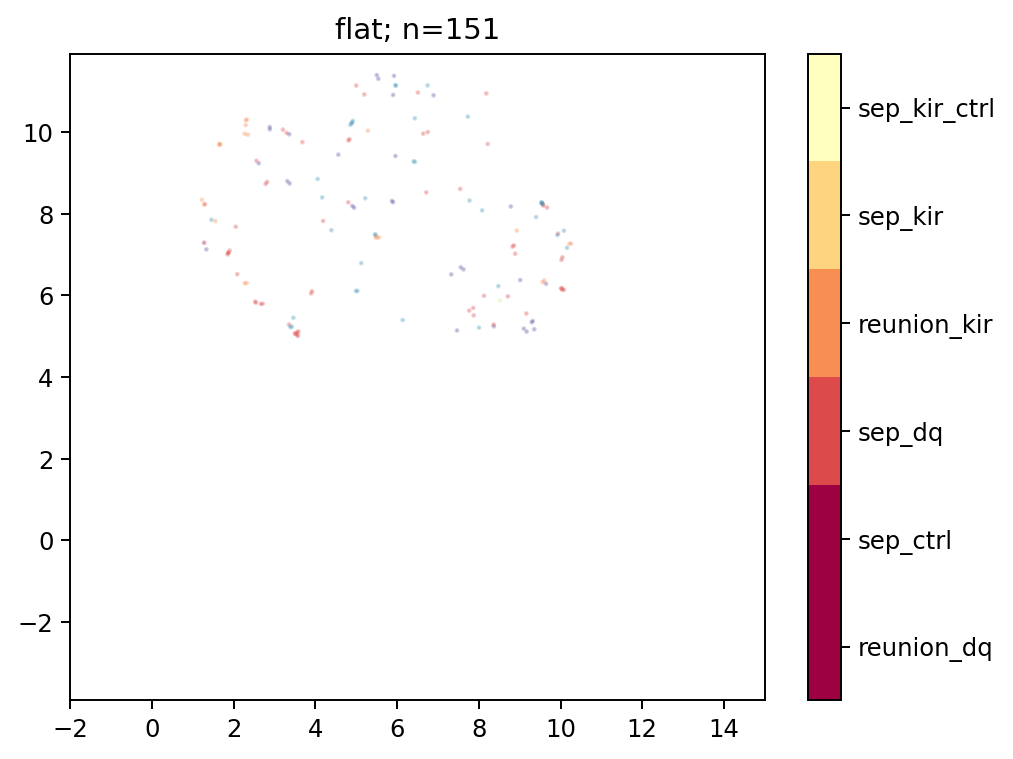

data points: 2
by groups: [('sep_ctrl', 2)];


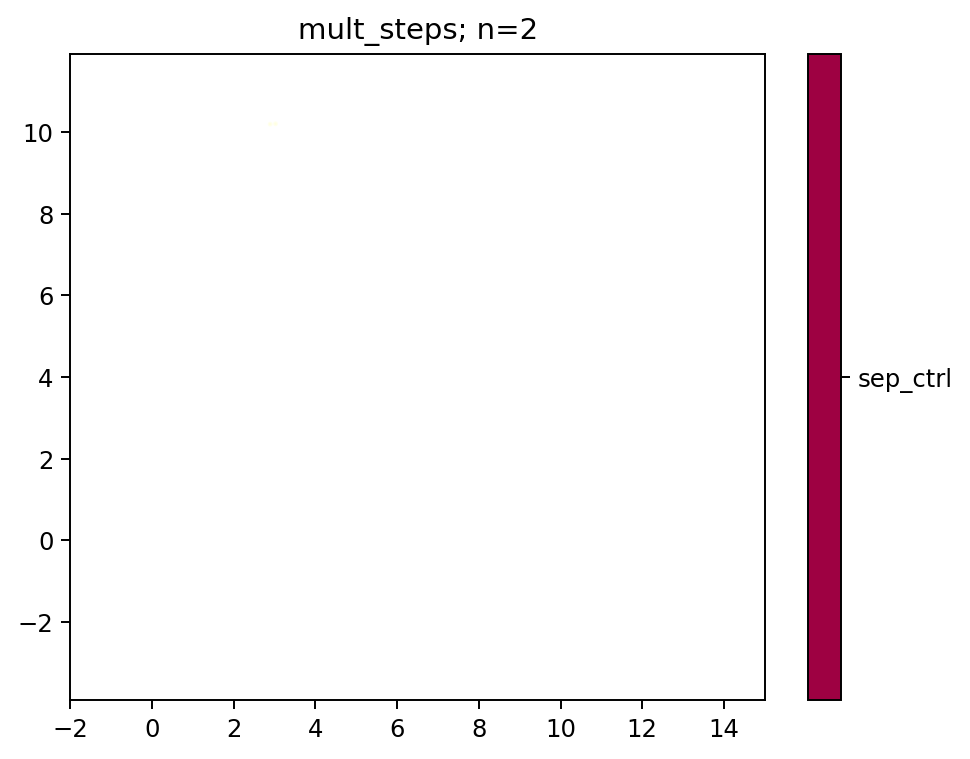

data points: 110
by groups: [('sep_ctrl', 20), ('sep_dq', 11), ('opto_acr', 2), ('reunion_kir', 1), ('reunion_kir_ctrl', 3), ('sep_kir', 34), ('sep_kir_ctrl', 39)];


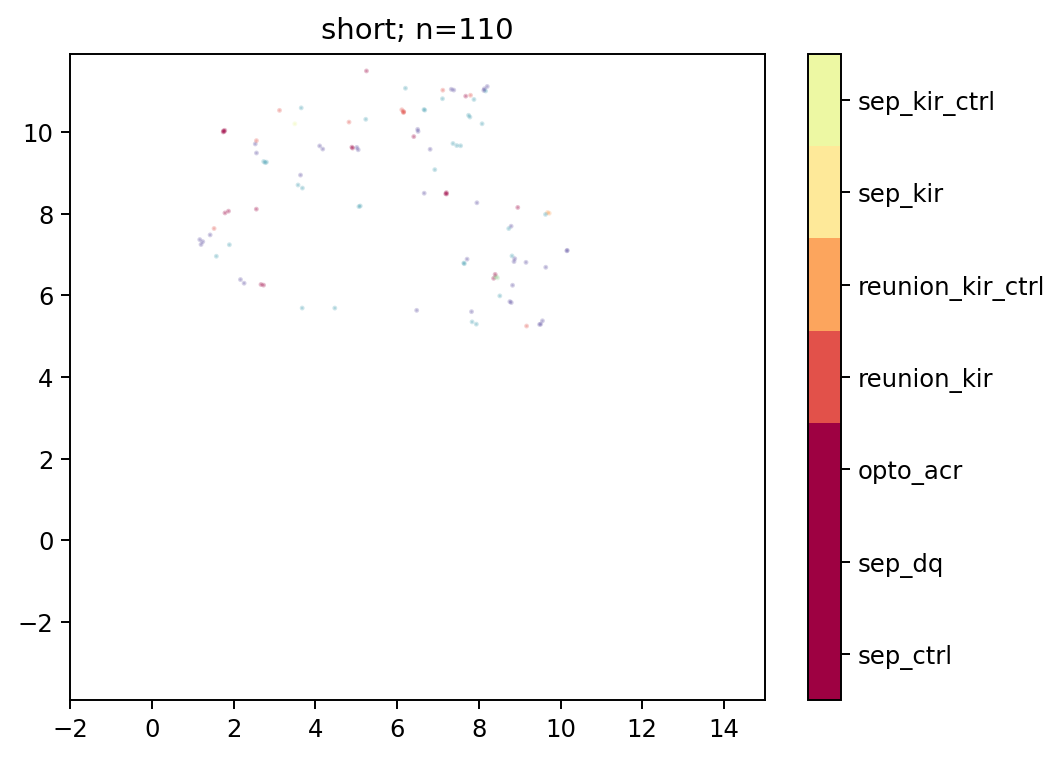

data points: 12
by groups: [('sep_ctrl', 5), ('sep_kir', 4), ('sep_kir_ctrl', 3)];


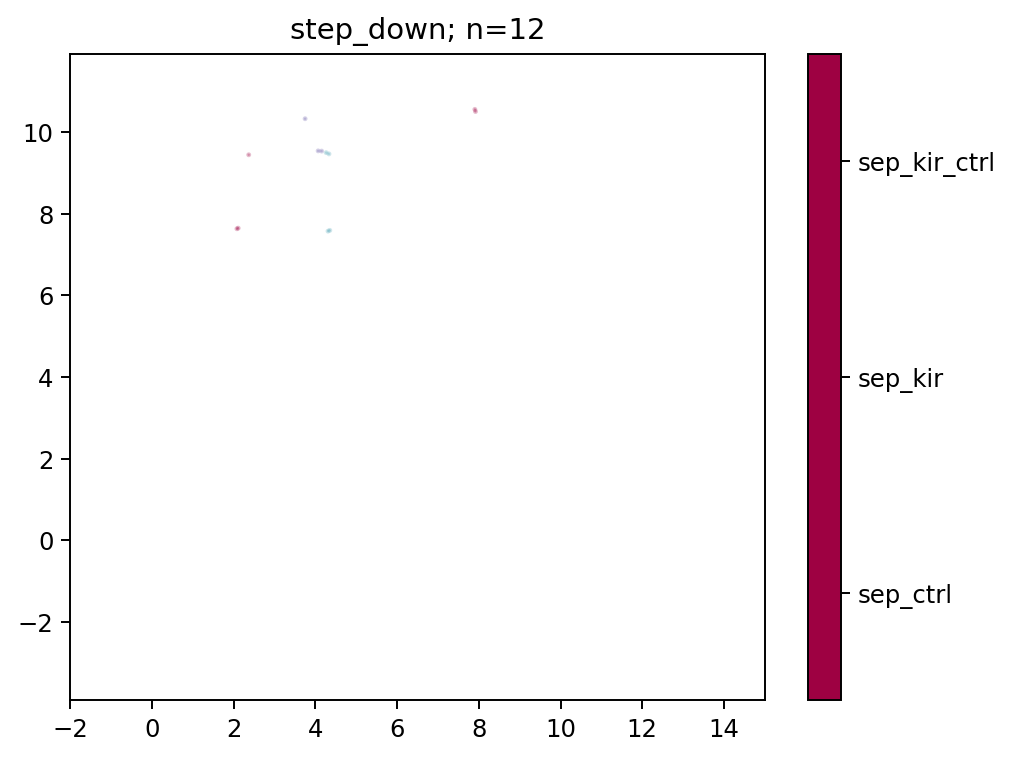

data points: 65
by groups: [('sep_ctrl', 18), ('sep_dq', 11), ('reunion_kir', 5), ('sep_kir', 14), ('sep_kir_ctrl', 17)];


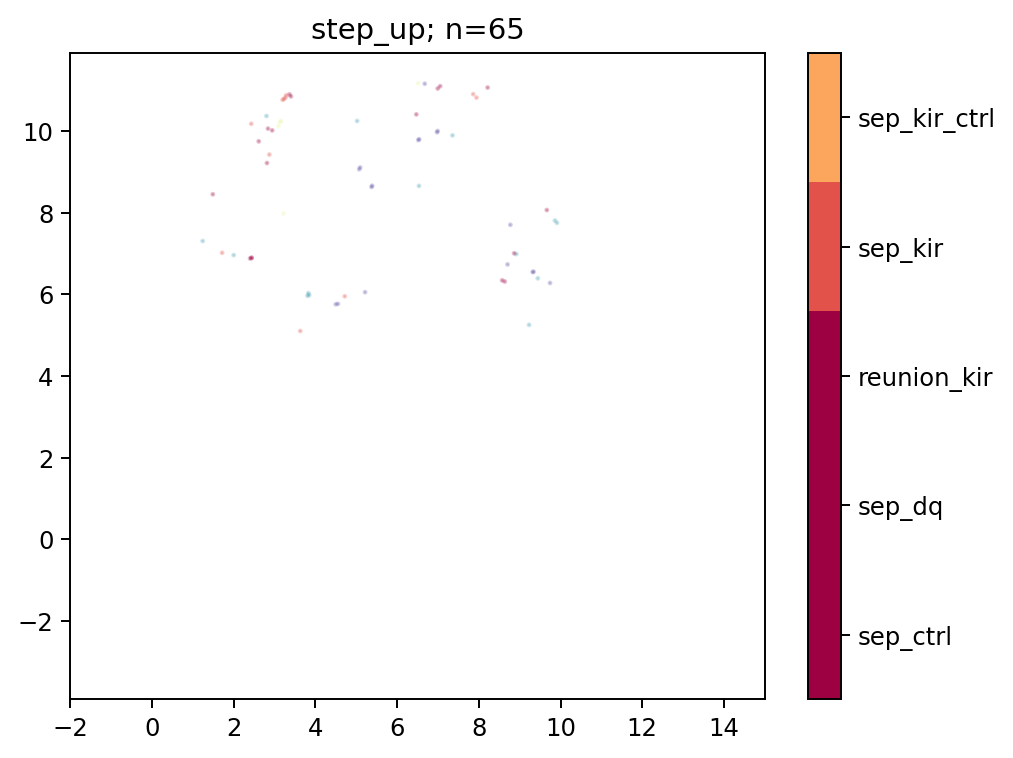

data points: 10
by groups: [('sep_ctrl', 1), ('sep_dq', 1), ('sep_kir', 4), ('sep_kir_ctrl', 4)];


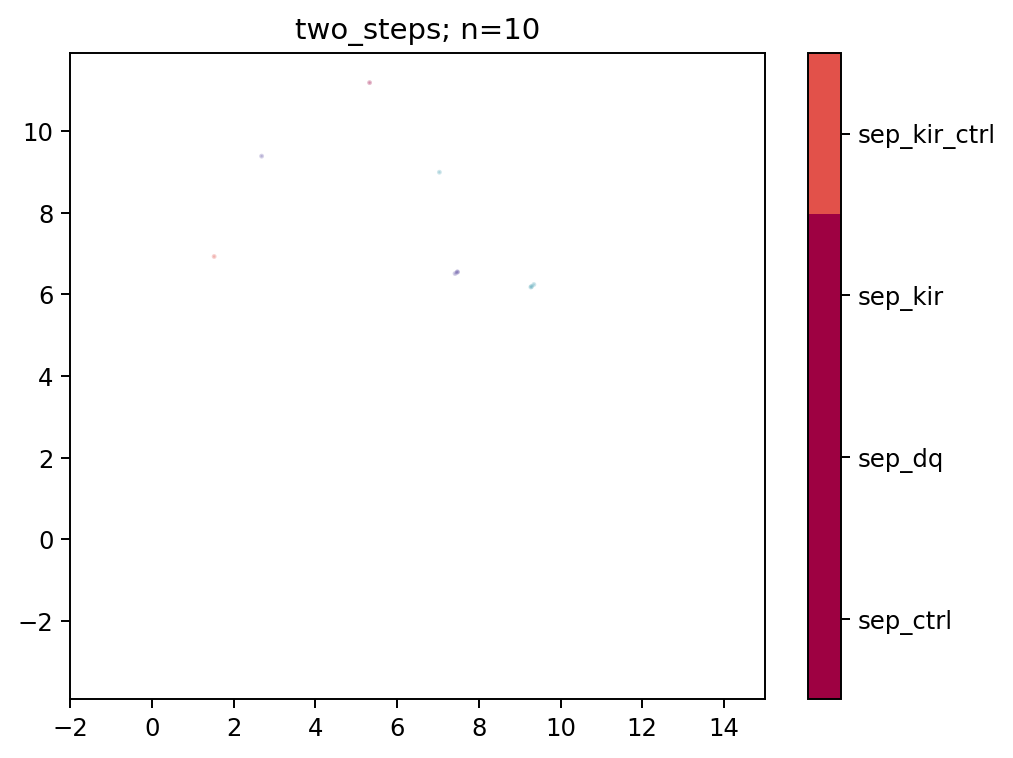

data points: 61
by groups: [('sep_ctrl', 20), ('sep_dq', 6), ('opto_acr', 1), ('reunion_kir', 2), ('sep_kir', 23), ('sep_kir_ctrl', 9)];


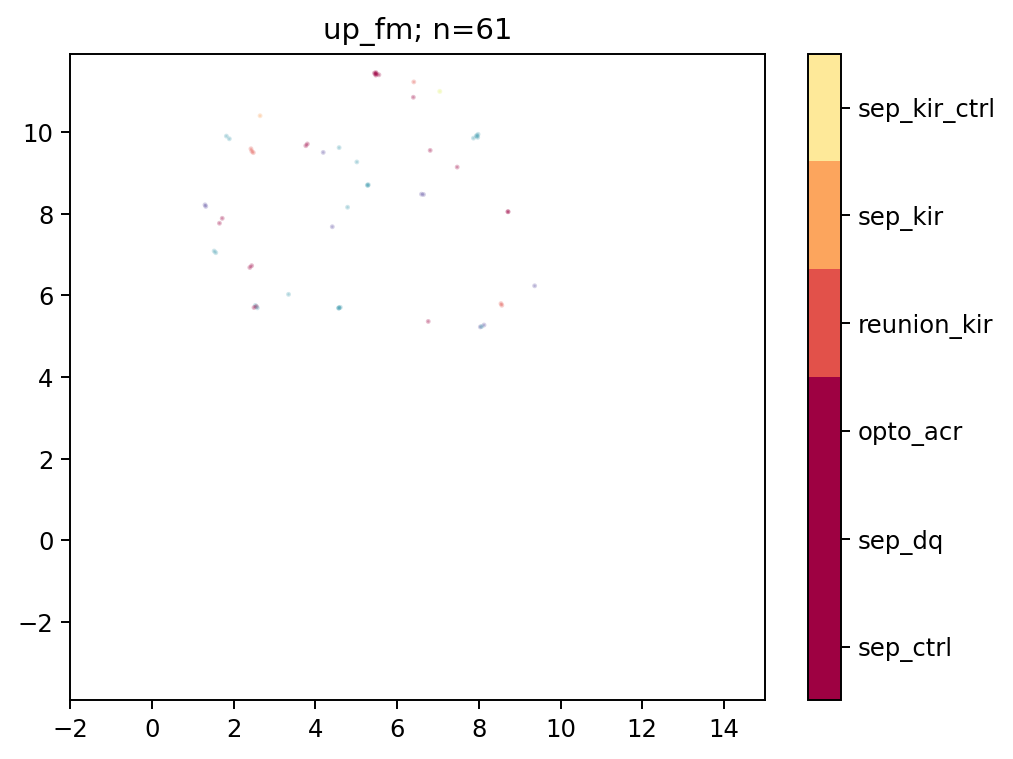

In [23]:
# plot UMAP embedding by group per vocal class

for gid in np.unique(classes_categorical):

    this_target = (classes_categorical == gid)
    print(f"data points: {sum(this_target)}")
    this_ddt = np.unique(targets[this_target], return_counts=True)
    ggs = [groups[aa-1] for aa in this_ddt[0]]
    print(f"by groups: {list(zip(ggs, this_ddt[1]))};")
    fig = plt.figure(dpi=175)
    plt.scatter(embedding[this_target, 0],
                embedding[this_target, 1],
                c=targets[this_target],
                cmap='Spectral',
                s=1,
                alpha=0.25)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(len(ggs)+1)+0.5)
    cbar.set_alpha(1)
    cbar.draw_all()
    cbar.set_ticks(np.arange(len(ggs))+1)
    cbar.set_ticklabels(ggs)
    plt.title(f'{classes_names[gid]}; n={sum(this_target)}', fontsize=12);
    plt.xlim([-2, 15])
    plt.ylim([-4, 12])
    plt.show()

### plot interactive UMAP embedding

In [15]:
# plot interactive UMAP embedding
# hover over dots to see spectrogram

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    img_data = img_data.reshape((256,256))
    image = Image.fromarray(img_data, mode='L').resize((64, 64), resample=Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

output_notebook()
bokeh_df = pd.DataFrame(embedding, columns=('x', 'y'))
bokeh_df['groups'] = [groups[x-1] for x in targets]
bokeh_df['image'] = list(map(embeddable_image, segmentation_masks))

datasource = ColumnDataSource(bokeh_df)
color_mapping = CategoricalColorMapper(factors=groups, palette=np.flip(Spectral10))

plot_figure = figure(
    title='UMAP projection',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 8px; color: #224499'>Group:</span>
        <span style='font-size: 9px'>@groups</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='groups', transform=color_mapping),
    line_alpha=0.1,
    fill_alpha=0.1,
    size=2
)
show(plot_figure)

Loading BokehJS ...